# EDA of Chatbot Arena Dataset 

The purpose of this notebook aims to explore the Chatbot Arena dataset, where two chatbots answer human questions, and users vote on the best response. The EDA of Chatbot Arena Dataset will cover:
- Understanding the dataset structure and contents.
- Exploring the distribution of questions, responses, and chatbots.
- Identifying patterns in the data to guide future modeling tasks.

## 1. Understanding the Dataset
The source dataset comes from https://huggingface.co/datasets/lmsys/chatbot_arena_conversations. The author describes the dataset as follows:

> This dataset contains 33K cleaned conversations with pairwise human preferences. It is collected from 13K unique IP addresses on the Chatbot Arena from April to June 2023. Each sample includes a question ID, two model names, their full conversation text in OpenAI API JSON format, the user vote, the anonymized user ID, the detected language tag, the OpenAI moderation API tag, the additional toxic tag, and the timestamp.

### Main Dataset

- **Conversation Data**
You can find the processed dataset in `./chatbot-arena-conversations.jsonl.gz`. The dataset is in JSON line format and compressed using gzip. It has gone through the following preprocessing steps to make analysis easier:

    - Removed non-English conversations.
    - Removed conversations with more than one round.
    - Removed conversations classified as toxic or harmful.

The dataset you will be working with contains `25282` rows (out of `33000` total rows) and `7` columns. The columns are:

- `question_id`: A unique identifier for the question.
- `model_a`: The name of the first chatbot model.
- `model_b`: The name of the second chatbot model.
- `winner`: The name of the chatbot model that won the user vote.
- `judge`: The anonymized user ID that voted.
- `conversation_a`: The conversation between the user and `model_a`.
- `conversation_b`: The conversation between the user and `model_b`.

An example of the data is as follows:

```json
{
  "question_id": "c0fc42c6f5f14f2aa5a89f71f8553730",
  "model_a": "vicuna-13b",
  "model_b": "koala-13b",
  "winner": "model_a",
  "judge": "arena_user_973",
  "conversation_a": [
    {
      "content": "Count from 1 to 10 with step = 3",
      "role": "user"
    },
    {
      "content": "1, 4, 7, 10\n\nCounting with a step of 3 means that you will increase the number by 3 each time. So, the first number is 1, the next is 4 (1 + 3), the next is 7 (4 + 3), and so on.",
      "role": "assistant"
    }
  ],
  "conversation_b": [
    {
      "content": "Count from 1 to 10 with step = 3",
      "role": "user"
    },
    {
      "content": "1, 4, 7, 10",
      "role": "assistant"
    }
  ]
}
```

### Auxiliary Datasets

There are four auxiliary datasets that you can use to help with your analysis:

- **Embedding Data**
    - `./chatbot-arena-prompts-embeddings.npy` contains the 256-dimensional text embeddings for each of the human questions. The embeddings are generated using OpenAI’s text-embedding model. We will explain what embeddings are and how you can use them later.
    - `./chatbot-arena-model_a_response-embeddings.npy` contains the 256-dimensional text embeddings for each of the model a responses (second half of conversation a). The embeddings are generated using OpenAI’s text-embedding model. 
     - `./chatbot-arena-model_b_response-embeddings.npy` contains the 256-dimensional text embeddings for each of of the model b responses (second half of conversation b). The embeddings are generated using OpenAI’s text-embedding model.

- **Topic Modeling and Hardness Score Data**
- `./chatbot-arena-gpt3-scores.jsonl.gz` ([example row](https://gist.github.com/simon-mo/25c5d532bccc7f28b404cffdfe719e6e#file-example-aux-row-json))
 contains labels for the dataset, which you can use for later modeling tasks. It has the following fields:
  - **question_id**: The unique identifier for the question, as seen in `./chatbot-arena-conversations.jsonl.gz`.
  - **prompt**: The extracted human question. This is equivalent to the first message in `conversation_a` and `conversation_b` in `./chatbot-arena-conversations.jsonl.gz`.
  - **openai_scores_raw_choices_nested**: The response from OpenAI GPT 3.5 model. It contains:
    - The evaluated topic model
    - The reason for a hardness score (from 1 to 10)
    - The score value

  For each prompt, we have 3 responses from GPT 3.5 because it is a probabilistic model. In the real world, multiple annotators may provide different labels for ground truth data. We extracted the following fields into columns:

  - **topic_modeling_1, topic_modeling_2, topic_modeling_3**: Topic modeling for the first, second, and third response. Each topic contains two words.
  - **score_reason_1, score_reason_2, score_reason_3**: The reasons for the hardness score for the first, second, and third response.
  - **score_value_1, score_value_2, score_value_3**: The hardness score for the first, second, and third response.
 
```json
{
  "question_id": "58210e39b3fd4441a2bd4a518bb44c2d",
  "prompt": "What is the difference between OpenCL and CUDA?",
  "openai_scores_raw_choices_nested": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "{\n    \"topic_modeling\": \"Technical Comparison\",\n    \"score_reason\": \"This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI's factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them.\",\n    \"score_value\": 9\n}",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null
      }
    },
    {
      "finish_reason": "stop",
      "index": 1,
      "logprobs": null,
      "message": {
        "content": "{\n    \"topic_modeling\": \"Software Comparison\",\n    \"score_reason\": \"This prompt assesses the AI's factual accuracy in distinguishing between two similar but distinct software frameworks.\",\n    \"score_value\": 8\n}",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null
      }
    },
    {
      "finish_reason": "stop",
      "index": 2,
      "logprobs": null,
      "message": {
        "content": "{\n    \"topic_modeling\": \"Comparison, Technology\",\n    \"score_reason\": \"This prompt requires the AI to demonstrate knowledge of two different technologies, compare their features, and explain their distinctions. This task assesses the AI's factual accuracy and proficiency in understanding complex technological concepts.\",\n    \"score_value\": 9\n}",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null
      }
    }
  ],
  "topic_modeling_1": "Technical Comparison",
  "score_reason_1": "This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI's factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them.",
  "score_value_1": 9,
  "topic_modeling_2": "Software Comparison",
  "score_reason_2": "This prompt assesses the AI's factual accuracy in distinguishing between two similar but distinct software frameworks.",
  "score_value_2": 8,
  "topic_modeling_3": "Comparison, Technology",
  "score_reason_3": "This prompt requires the AI to demonstrate knowledge of two different technologies, compare their features, and explain their distinctions. This task assesses the AI's factual accuracy and proficiency in understanding complex technological concepts.",
  "score_value_3": 9
}
```

## 2. Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_theme(style="whitegrid")

In [2]:
# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section
df = pd.read_json(
    "../training_data/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [3]:
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "../training_data/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "../training_data/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "../training_data/chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "../training_data/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

## 3. Exploring the Data

### Main Data Set - Converstation Data

Let's investigate the conversation data first (`chatbot-arena-conversations.jsonl.gz`).

In [4]:
# Check the shape of the data.
df.shape

(25282, 7)

In [5]:
# View the data.
df.head()

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25282 entries, 0 to 25281
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     25282 non-null  object
 1   model_a         25282 non-null  object
 2   model_b         25282 non-null  object
 3   winner          25282 non-null  object
 4   judge           25282 non-null  object
 5   conversation_a  25282 non-null  object
 6   conversation_b  25282 non-null  object
dtypes: object(7)
memory usage: 1.4+ MB


In [7]:
df.isnull().sum()

question_id       0
model_a           0
model_b           0
winner            0
judge             0
conversation_a    0
conversation_b    0
dtype: int64

From paragraph one above, we understand the structure of each column in the dataset. Let us create new columns: prompt, and prompt_length and perform analysis on these variables.

In [8]:
df["conversation_a"].iloc[0]

[{'content': 'What is the difference between OpenCL and CUDA?',
  'role': 'user'},
 {'content': 'OpenCL and CUDA are two different programming models that are used for parallel computing.OpenCL is a general-purpose并行编程接口 that allows developers to write parallel code that can run on any platform that supportsCL, which includes most modern operating systems and computer systems, including Windows, Linux, and macOS. It provides a lower-level, more flexible API that is more suitable for building large-scale distributed computing systems.CUDA is a specific implementation ofOpenCL that is designed for performance and scalability in devices with multiple GPU(s). It was developed by Nvidia and is widely used for scientific computing, machine learning, and图形图像处理. The CUDA API provides a high-level, more efficient way to write parallel code that can run on top of a GPU, while still maintaining the ability to write code that can be easily adapted for other parallel computing platforms.',
  'role'

In [9]:
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt_length"] = df["prompt"].str.len()

In [10]:
# View statistics for the prompt length
df["prompt_length"].describe()

count    25282.00000
mean       196.74646
std        369.05595
min         16.00000
25%         42.00000
50%         72.00000
75%        156.00000
max       2560.00000
Name: prompt_length, dtype: float64

Since the median is less than the mean prompt length, this distribution is right skewed. Let's visualize this.

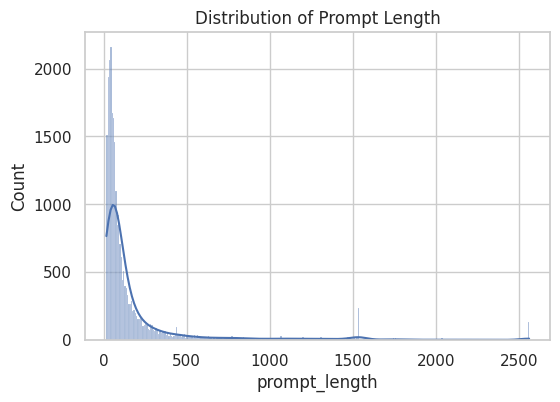

In [11]:
# Plot the distribution of the length of the prompt
plt.figure(figsize=(6, 4))
sns.histplot(df["prompt_length"], kde=True)
plt.title("Distribution of Prompt Length")
plt.show();

Let's apply this same process to the reponse length for models a and b.

In [12]:
df["response_a"] = df["conversation_a"].str[1].str["content"]
df["response_length_a"] = df["response_a"].str.len()
# View the statistics of the response length
df["response_length_a"].describe()


count    25282.000000
mean       772.708409
std        655.798032
min          1.000000
25%        232.000000
50%        591.000000
75%       1215.750000
max       9857.000000
Name: response_length_a, dtype: float64

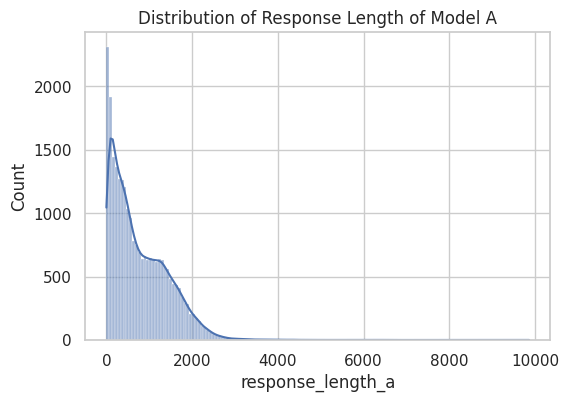

In [13]:
# Plot the distribution of the length of the response of model a.
plt.figure(figsize=(6, 4))
sns.histplot(df["response_length_a"], kde=True)
plt.title("Distribution of Response Length of Model A")
plt.show();

In [14]:
df["response_b"] = df["conversation_b"].str[1].str["content"]
df["response_length_b"] = df["response_b"].str.len()
# View the statistics of the response length
df["response_length_b"].describe()

count    25282.000000
mean       773.163911
std        658.803491
min          1.000000
25%        232.000000
50%        582.000000
75%       1214.750000
max       7135.000000
Name: response_length_b, dtype: float64

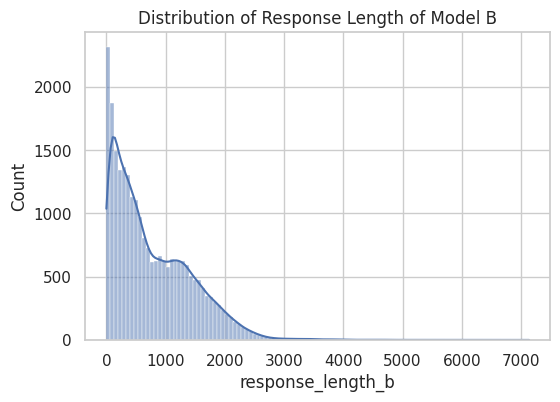

In [15]:
# Plot the distribution of the length of the response of model b.
plt.figure(figsize=(6, 4))
sns.histplot(df["response_length_b"], kde=True)
plt.title("Distribution of Response Length of Model B")
plt.show();

Given that our auxilliary data set contains embedding from only the second half of the data from the main data set, let's view the distribution for that specific data.

In [16]:
df["model_a_response"] = df["conversation_a"].str[1].str["content"].iloc[len(df)//2:]
df["model_a_response_length"] = df["model_a_response"].str.len()
# View the statistics of the response length
df["model_a_response_length"].describe()

count    12641.000000
mean       807.142710
std        643.105958
min          1.000000
25%        261.000000
50%        655.000000
75%       1269.000000
max       5857.000000
Name: model_a_response_length, dtype: float64

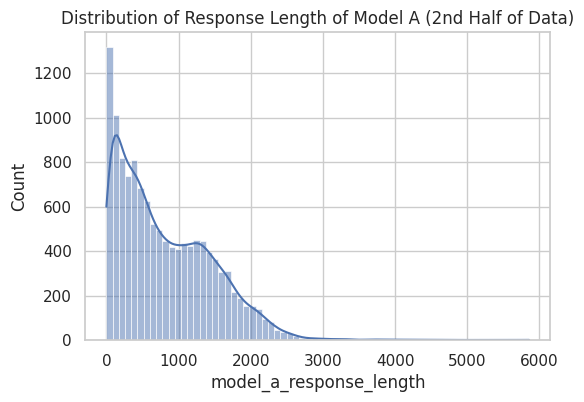

In [17]:
# Plot the distribution of the length of the response of model a..
plt.figure(figsize=(6, 4))
sns.histplot(df["model_a_response_length"], kde=True)
plt.title("Distribution of Response Length of Model A (2nd Half of Data)")
plt.show();

In [18]:
df["model_b_response"] = df["conversation_b"].str[1].str["content"].iloc[len(df)//2:]
df["model_b_response_length"] = df["model_b_response"].str.len()
# View the statistics of the response length
df["model_b_response_length"].describe()

count    12641.000000
mean       810.890119
std        659.900188
min          1.000000
25%        261.000000
50%        634.000000
75%       1279.000000
max       7135.000000
Name: model_b_response_length, dtype: float64

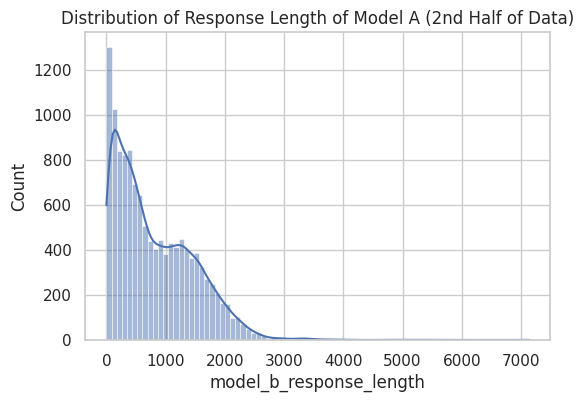

In [19]:
# Plot the distribution of the length of the response of model a..
plt.figure(figsize=(6, 4))
sns.histplot(df["model_b_response_length"], kde=True)
plt.title("Distribution of Response Length of Model A (2nd Half of Data)")
plt.show();

Now lets look at the distribution of the questions. We know from the shape of the data that there are 25282 rows in the data set.

In [20]:
# Determine the number of unique questions
df["question_id"].nunique()

25272

In [21]:
# Check for duplicate entris in the df
df[df["question_id"].duplicated(keep = False)].head(2)

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,prompt_length,response_a,response_length_a,response_b,response_length_b,model_a_response,model_a_response_length,model_b_response,model_b_response_length
1576,20cb94a0b7c147fe8fc6250b2a20fd1c,oasst-pythia-12b,llama-13b,tie,arena_user_2628,[{'content': 'Write a song for my favourite si...,[{'content': 'Write a song for my favourite si...,Write a song for my favourite singer: Zhou She...,143,"Here's a song for Zhou Shen, ""From the Hill to...",644,All the lyrics are written in the song.,39,NaN,NaN,NaN,NaN
1577,20cb94a0b7c147fe8fc6250b2a20fd1c,oasst-pythia-12b,llama-13b,model_a,arena_user_2628,[{'content': 'Write a song for my favourite si...,[{'content': 'Write a song for my favourite si...,Write a song for my favourite singer: Zhou She...,143,"Here's a song for Zhou Shen, ""From the Hill to...",644,All the lyrics are written in the song.,39,NaN,NaN,NaN,NaN


In [22]:
df["winner"].unique()

array(['model_b', 'tie', 'model_a', 'tie (bothbad)'], dtype=object)

In [23]:
df["winner"].value_counts()

winner
model_a          9002
model_b          8862
tie (bothbad)    4632
tie              2786
Name: count, dtype: int64

In [24]:
# Check if model a and model b contains the same models
if set(df["model_a"].unique()) == set(df["model_b"].unique()):
    print(df["model_a"].unique())

['chatglm-6b' 'oasst-pythia-12b' 'koala-13b' 'vicuna-13b'
 'stablelm-tuned-alpha-7b' 'alpaca-13b' 'llama-13b' 'dolly-v2-12b'
 'fastchat-t5-3b' 'gpt-3.5-turbo' 'gpt-4' 'claude-v1' 'RWKV-4-Raven-14B'
 'mpt-7b-chat' 'palm-2' 'claude-instant-v1' 'vicuna-7b' 'wizardlm-13b'
 'gpt4all-13b-snoozy' 'guanaco-33b']


In [25]:
len(df["model_a"].unique())

20

Let's visualize some data for the top five highest performing models.

In [26]:
# Create a new dataframe only which contains winning models
win_filt = df[df["winner"].isin(["model_a", "model_b"])].copy()

# Create a new column with the name of the winning model
win_filt["winning_model"] = win_filt.apply(lambda x: x["model_a"] if x["winner"] == "model_a" else x["model_b"], axis = 1)

# Determine the top five highest performing models based on win counts
top_models = win_filt.groupby(["winning_model"]).size().reset_index(name = "win_count")
top_models = top_models.sort_values(by = "win_count", ascending = False).head()
top_models

,winning_model,win_count
8,gpt-4,2218
17,vicuna-13b,1974
7,gpt-3.5-turbo,1922
4,claude-v1,1865
11,koala-13b,1487


In [27]:
# Create a column with the winning response length.
win_filt["winning_response"] = np.where(win_filt["winner"] == "model_a", win_filt["response_length_a"], win_filt["response_length_b"])

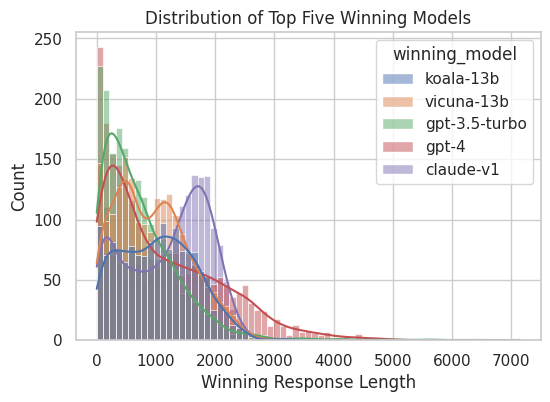

In [28]:
# Obtain the top five winning models.
top_five = list(top_models["winning_model"])

# Filter the top models to only include the top five models
df_top_five = win_filt[win_filt["winning_model"].isin(top_five)]

# Plot the distribution of the top five models
plt.figure(figsize=(6, 4))
sns.histplot(data = df_top_five, x = "winning_response", hue = "winning_model", kde = True)
plt.title("Distribution of Top Five Winning Models")
plt.xlabel("Winning Response Length")
plt.show();

In [29]:
win_filt["winning_response"].describe()

count    17864.000000
mean       929.744402
std        706.046803
min          1.000000
25%        333.000000
50%        823.000000
75%       1412.000000
max       7135.000000
Name: winning_response, dtype: float64

In [30]:
top_five

['gpt-4', 'vicuna-13b', 'gpt-3.5-turbo', 'claude-v1', 'koala-13b']

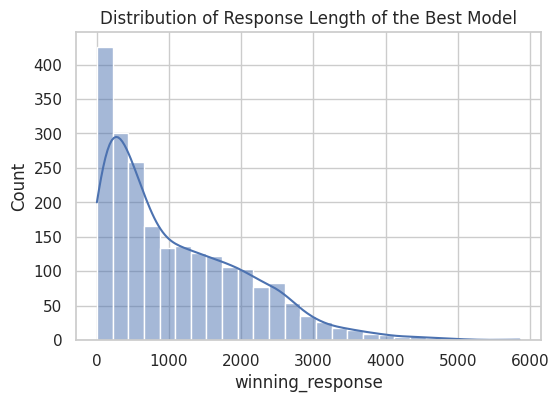

In [31]:
# Obtain information about the best performing model
best_model = win_filt[win_filt["winning_model"] == 'gpt-4']

# Plot the distribution of the length of the response of model a..
plt.figure(figsize=(6, 4))
sns.histplot(best_model["winning_response"], kde=True)
plt.title("Distribution of Response Length of the Best Model")
plt.show();

In [32]:
best_model["winning_response"].describe()

count    2218.000000
mean     1099.282236
std       963.181024
min         1.000000
25%       297.000000
50%       815.500000
75%      1721.750000
max      5857.000000
Name: winning_response, dtype: float64

### Observations from the Main Data Set

 - Do the arena users ask long or short questions? What is the average length of prompts users give to the chatbots?

 Based on the right skewed distribution of prompt length, arena users tend to ask questions with total prompt lengths of less than 500 words. The average arena user will prompt a model with a question which is around 200 words.

 - Describe the length of the response for models in general. In general, what is the average response length for a model?

 The distributions for the response length of model a and model b represent the general case of model response. Based on these distributions a model will generally respond in less than 3000 words. The statistics from model a response length and model b response length are approximately the same because they both represent the general case. Generally, a model will respond with an average of about 800 words, with 75% of responses being less than 1200 words. Observe that the distribution for response length is right skewed, where shorter responses of about 200 words are the most frequent. Additionally, there is another common general response length of about 1000 words which is the next most frequent response length.

 - What are the top five models based on winning from either model a or model b?

 The top five models based on the total number of wins ini descending order are: 'gpt-4', 'vicuna-13b', 'gpt-3.5-turbo', 'claude-v1', and 'koala-13b'.

 - Describe the distribution of the top five models based solely on wins. What is the average response length of the top five models compared to models in general?

 The response length distribution of the top five models is right skewed. All of the top five models generally respond in less than 3000 words, except for 'gpt-4' which will occasionally respond with up to about 5000 words. Three of the top five models will most frequently respond with around 500 words. For the other two models: 'koala-13b' will most frequently respond with about 1200 words, and 'claude-v1' will respond most frequently with about 1800 words. The average response length of the top five models is about 930 words, where 75% of responses are less than about 1400 words.

 - What is the best model based solely on wins? Describe it's distribution and compare its statistics versus the general case of the top five models.

 The best model based solely on wins is 'gpt-4' with 2218 wins. This is approximately 250 more wins than the next best model,'vicuna-13b'. It is most frequent for 'gpt-4' to respond with about 150 words. The average response length of 'gpt-4' is about 1100 words, where 50% of the responses are less than 815 words. Even though the average length of the response of 'gpt-4' is greater than that of the general case of the average response length of the top five models (about 930 words), 'gpt-4' will respond most frequently with fewer words as compared to the other models in the top five models. This means that the quality of the response of 'gpt-4' can be significantly better than that of other models, while generalizing its solution to a fewer number of words, more frequently. However, it should be noted that 'gpt-3.5-turbo' is the third best model and generalizes its responses to approximately 150 words more frequently than 'gpt-4'. By observing the distribution of 'gpt-4' versus 'gpt-3.5-turbo' you can see that 'gpt-4' is capable of producing resposes which are much longer than 'gpt-3.5-turbo'. This could indicate that 'gpt-4' has been trained on more data, or has been tuned to be able to provide better responses to the users.



### Auxilliary Data Set - Prompt Embeddings

Text embedding models transform natural language text into numerical vectors. The vectors are generated in such a way that semantically similar text are close to each other in the vector space. In the real world, these embeddings to find similar questions or to cluster the questions.

Lets' investigate the prompy embedding data (`./chatbot-arena-prompts-embeddings.npy`). This dataset contains 256-dimensional text embeddings for each of the user prompts, each embedding is a 256-dimensional vector that represents the semantic meaning of a prompt. These vectors allow us to compare prompts based on their content.

In this section we will be computing the similarity between prompts using the precomputed embeddings. The goal is to find prompts that are similar to a given prompt based on their embeddings.


In [33]:
# View the data
prompt_embeddings

array([[-0.12376316, -0.1173524 ,  0.04567662, ..., -0.02439648,
        -0.03724024, -0.04380682],
       [ 0.00602781,  0.02843601, -0.09102212, ...,  0.08506154,
        -0.05333152,  0.00185428],
       [-0.03522179, -0.10940242, -0.02224718, ..., -0.14116742,
         0.00477351,  0.00416916],
       ...,
       [ 0.02476096, -0.02741823,  0.07049022, ..., -0.05541623,
        -0.02461602,  0.06005438],
       [ 0.01620374,  0.04473886,  0.08496623, ..., -0.02189322,
        -0.05438842,  0.02849752],
       [-0.04179214,  0.00963908, -0.00338678, ...,  0.08221702,
        -0.02381286, -0.10591594]], dtype=float32)

The embeddings are a matrix where each row corresponds to a prompt from the dataset. Each row is a 256-dimensional vector that captures the semantic meaning of the prompt.

In [34]:
# Check the shape of the data
prompt_embeddings.shape

(25282, 256)

The embeddings array has a shape of `(25282, 256)`, meaning there are 25,282 embeddings (one for each prompt), and each embedding is a 256-dimensional vector.

Next, we will:
1. Take a sample of the embeddings to reduce computation time.
2. Compute the dot product between the embeddings to measure similarity.
3. Retrieve the most similar prompts to a chosen source prompt.
4. Output the top 5 similar prompts.
(This is related to the ``(Open-ended) Explore the prompt topics in the dataset (topic modeling).'' requirement of the EDA assignment)

Start by taking a sample of the embeddings and calculating the similarity between them using the dot product.

In [35]:
# Sample the first 1000 prompts.
embeddings_sample = prompt_embeddings[:1000]

# Measure the similarity of the embeddings by computing the dot product.
dot_product = np.dot(embeddings_sample, embeddings_sample.T)

# Check the shape of the dot product
dot_product.shape

(1000, 1000)

Given the above output, the dot product matrix has a shape of (1000, 1000), meaning we have similarity scores between all pairs of prompts in our sample of 1000.

Next, let's choose a prompt and find the top 5 most similar prompts based on the computed similarity.

In [36]:
# Select a prompt from the dataframe based on integer indexing.
source_prompt_idx = 16
source_prompt = df.iloc[source_prompt_idx].prompt
source_prompt

'could you explain quantum mechanics for me?'

The prompt we're using as a reference (index 16) is:

`'could you explain quantum mechanics for me?'`

Now let's find the top 5 most similar prompts to this one.

In [37]:
# Assign a value for the number of similar prompts to find based on the integer indexed prompt
top_k = 5

# Determine the index of similar prompts using argsort to compute the similarity of the 1000 
# sampled prompts versus the integer indexed prompt, sorted in descending order. Then slice the 
# top_k elements from the bottom of the list and return them in descending order by similarity.
similar_promts_idx = np.argsort(dot_product[source_prompt_idx])[-top_k:][::-1]

# Locate the similar prompts by integer indexing
similar_promts = df.iloc[similar_promts_idx].prompt

# Output the similar prompts in a list.
similar_promts.tolist()

['could you explain quantum mechanics for me?',
 'Explain quantum computing in simple terms',
 'Explain quantum computing like I’m a six grader',
 'What can you tell me about quantum chromodynamics?',
 'can you eli5 quantum tunneling?']

As you can see, these prompts are closely related to programming tasks, many of them dealing with functions and computations. This shows how embeddings can group semantically similar questions together.

### Auxilliary Data Set - Model A Response Embeddings

Lets' investigate the prompy embedding data (`./chatbot-arena-model_a_response-embeddings.npy`). This dataset contains 256-dimensional text embeddings for each of model a responses. This is the embedding from `model_a_response` created by extracting the second half of the column `conversation_a` from the main data set. Similar to above, each embedding is a 256-dimensional vector that represents the semantic meaning of a prompt. These vectors allow us to compare prompts based on their content.

In this section we will be computing the similarity between responses from Model A using the precomputed embeddings. The goal is to find responses that are similar to a given response based on their embeddings.

In [38]:
# View the data
response_a_embeddings

array([[-0.1491493 , -0.08669585,  0.09805102, ..., -0.02593215,
         0.02883854, -0.07313272],
       [ 0.02954244,  0.05492629, -0.02558972, ...,  0.07534866,
        -0.02692788, -0.066208  ],
       [ 0.01025808, -0.09417554,  0.01474317, ..., -0.10547299,
         0.08545391,  0.01333099],
       ...,
       [-0.01922561,  0.01210033,  0.10417487, ..., -0.04531752,
         0.05281021,  0.06230255],
       [-0.00278411,  0.01896625,  0.1015662 , ..., -0.04843859,
         0.02523672, -0.02559061],
       [-0.00859832, -0.00813303,  0.04082992, ...,  0.05036854,
         0.0294495 , -0.11849596]], dtype=float32)

In [39]:
response_a_embeddings.shape

(25282, 256)

In [40]:
# Let's try to find the closest prompt to a given prompt
embeddings_sample = response_a_embeddings[:1000]

# Compute the dot product between the embeddings
dot_product = np.dot(embeddings_sample, embeddings_sample.T)
dot_product.shape

(1000, 1000)

In [41]:
response_prompt_idx = 16
response_prompt = df.iloc[response_prompt_idx].response_a
response_prompt

'Quantum mechanics is a branch of physics that deals with the behavior of matter and energy at the atomic and subatomic level. It is based on the principles of wave-particle duality, uncertainty principle, and complementarity.\n\nIn classical mechanics, objects are described by their position and velocity, and the laws of physics describe how these properties change over time. However, at the atomic and subatomic level, the behavior of objects is not described by classical mechanics, but by the principles of quantum mechanics.\n\nOne of the key principles of quantum mechanics is wave-particle duality, which states that particles can exhibit both wave-like and particle-like behavior. This means that particles can be described by a wave function, which gives the probability of finding the particle at a particular location in space.\n\nAnother key principle is the uncertainty principle, which states that certain pairs of properties, such as position and momentum, cannot be known with abso

In [42]:
top_k = 5
similar_promts_idx = np.argsort(dot_product[response_prompt_idx])[-top_k:][::-1]
similar_promts = df.iloc[similar_promts_idx].response_a
similar_promts.tolist()

['Quantum mechanics is a branch of physics that deals with the behavior of matter and energy at the atomic and subatomic level. It is based on the principles of wave-particle duality, uncertainty principle, and complementarity.\n\nIn classical mechanics, objects are described by their position and velocity, and the laws of physics describe how these properties change over time. However, at the atomic and subatomic level, the behavior of objects is not described by classical mechanics, but by the principles of quantum mechanics.\n\nOne of the key principles of quantum mechanics is wave-particle duality, which states that particles can exhibit both wave-like and particle-like behavior. This means that particles can be described by a wave function, which gives the probability of finding the particle at a particular location in space.\n\nAnother key principle is the uncertainty principle, which states that certain pairs of properties, such as position and momentum, cannot be known with abs

### Auxilliary Data Set - Model B Response Embeddings


Lets' investigate the prompy embedding data (`./chatbot-arena-model_b_response-embeddings.npy`). This dataset contains 256-dimensional text embeddings for each of model b responses. This is the embedding from `model_b_response` created by extracting the second half of the column `conversation_b` from the main data set. Similar to above, each embedding is a 256-dimensional vector that represents the semantic meaning of a prompt. These vectors allow us to compare prompts based on their content.

In this section we will be computing the similarity between responses from Model B using the precomputed embeddings. The goal is to find responses that are similar to a given response based on their embeddings.

In [43]:
# View the data
response_b_embeddings

array([[-0.12210688, -0.07771916,  0.12194429, ..., -0.02888047,
         0.00501496, -0.06190705],
       [ 0.02394216, -0.06510714, -0.05676256, ..., -0.03929716,
        -0.04730213, -0.03767191],
       [-0.04066539, -0.10329008, -0.0168253 , ..., -0.11028453,
         0.08474667, -0.05624023],
       ...,
       [ 0.02052799,  0.04245432,  0.01636738, ..., -0.11397564,
         0.00396863,  0.06505689],
       [ 0.00634935,  0.02982271,  0.11510068, ..., -0.04793011,
         0.07726112,  0.005072  ],
       [-0.01989259,  0.01122532, -0.0082961 , ...,  0.08924079,
         0.01362286, -0.1503932 ]], dtype=float32)

In [44]:
response_a_embeddings.shape

(25282, 256)

In [45]:
# Let's try to find the closest prompt to a given prompt
embeddings_sample = response_b_embeddings[:1000]

# Compute the dot product between the embeddings
dot_product = np.dot(embeddings_sample, embeddings_sample.T)
dot_product.shape

(1000, 1000)

In [46]:
response_prompt_idx = 16
response_prompt = df.iloc[response_prompt_idx].response_b
response_prompt

'Quantum mechanics is a branch of physics that deals with the behavior of matter and energy at the atomic and subatomic level. It is based on the principles of classical mechanics, but it differs in important ways. Here is a simplified explanation of the basics of quantum mechanics:\n\n1.   Atoms are made up of particles.\n2.   Particles can be described using a set of properties called quantum numbers, such as energy, momentum, angular momentum, and identity.\n3.   Particles can be in different energy states, and the energy of a particle can be described using a mathematical function called the wave function.\n4.   The wave function can be used to describe the probability of a particle being in a certain energy state.\n5.   Particles can also be described using a set of rules called the Schrödinger equation, which describes how the wave function changes over time.\n6.   The wave function can be used to describe the behavior of particles in a system, such as how they will interact with

In [47]:
top_k = 5
similar_promts_idx = np.argsort(dot_product[response_prompt_idx])[-top_k:][::-1]
similar_promts = df.iloc[similar_promts_idx].response_b
similar_promts.tolist()

['Quantum mechanics is a branch of physics that deals with the behavior of matter and energy at the atomic and subatomic level. It is based on the principles of classical mechanics, but it differs in important ways. Here is a simplified explanation of the basics of quantum mechanics:\n\n1.   Atoms are made up of particles.\n2.   Particles can be described using a set of properties called quantum numbers, such as energy, momentum, angular momentum, and identity.\n3.   Particles can be in different energy states, and the energy of a particle can be described using a mathematical function called the wave function.\n4.   The wave function can be used to describe the probability of a particle being in a certain energy state.\n5.   Particles can also be described using a set of rules called the Schrödinger equation, which describes how the wave function changes over time.\n6.   The wave function can be used to describe the behavior of particles in a system, such as how they will interact wit

Potential follow-up questions you can explore: 
- Can you identify clusters of similar topics within the dataset?
- How do different models perform on similar prompts?
- Can you find examples where semantically similar prompts result in different outcomes?

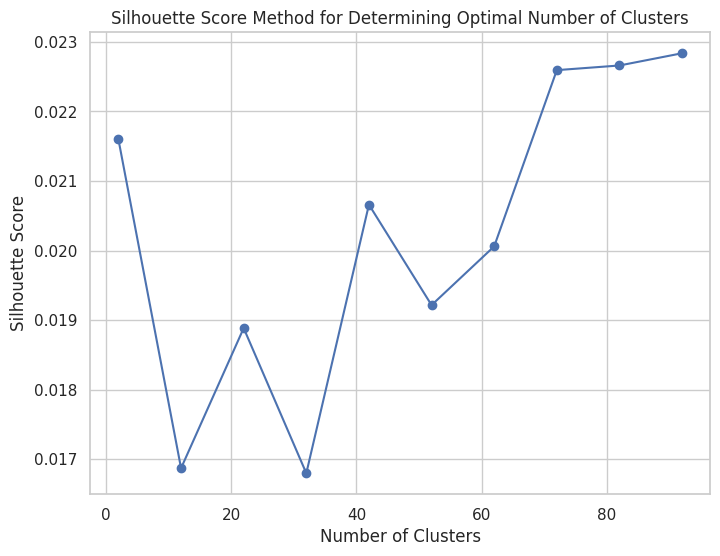

In [48]:
# Create a plot of silhouette score versus number of clusters.

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Create an empty list to store the silhouette scores
silhouette_scores = []

# Create a range of clusters
range_n_clusters = range(2, 100, 10)


for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(response_a_embeddings)
    silhouette_avg = silhouette_score(response_a_embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores for each number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method for Determining Optimal Number of Clusters')
plt.show();

### Auxilliary Data Set - Topic Modeling and Hardness Score Data

Now, let's explore the second auxiliary dataset `./chatbot-arena-gpt3-scores.jsonl.gz`, which contains valuable information for later modeling tasks. 

For each prompt, there are 3 responses, as GPT-3.5 is probabilistic. This means we get multiple labels for a single prompt, similar to how real-world datasets can have multiple annotations.

Let's start by loading and inspecting the first 5 rows of this dataset to understand its structure.

**_Warning_: This data can be messy! This is intentionally not cleaned up for you to resemble real-world data. You are responsible for figuring out the irregularities and cleaning it up. The following cells demonstrate the example of messy data.**

In [49]:
# View the data
topic_and_hardness.head(5)

,question_id,prompt,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3
0,58210e39b3fd4441a2bd4a518bb44c2d,What is the difference between OpenCL and CUDA?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Technical Comparison,This prompt requires the AI to accurately comp...,9,Software Comparison,This prompt assesses the AI's factual accuracy...,8,"Comparison, Technology",This prompt requires the AI to demonstrate kno...,9
1,2564acd09e3942fd97657d05282d4389,Why did my parent not invite me to their wedding?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...","Reasoning, Emotion",This prompt requires the AI to understand huma...,9,"Emotions, Relationships",This prompt involves understanding complex hum...,8,"Reasoning, Emotional",This prompt challenges the AI to infer motives...,8
2,90bfd142157948aba01931726c888e7f,"Fuji vs. Nikon, which is better?","[{'finish_reason': 'stop', 'index': 0, 'logpro...",Camera comparison,This prompt does not require problem-solving s...,2,Comparative Analysis,This prompt assesses the AI's ability to analy...,6,Photography comparison,This prompt is subjective and does not provide...,2
3,a7c5accc53e649a3bc6b2e41d962ebc4,How to build an arena for chatbots?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Chatbot Arena,This prompt requires problem-solving skills an...,8,Chatbot Arena,This prompt requires the AI to engage in probl...,8,Chatbot Arena,This prompt requires problem-solving skills an...,8
4,adf27e819a3c494cb6e993f0c660e097,When is it today?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Time Query,This prompt is very straightforward and does n...,2,Date Inquiry,This prompt is very straightforward and does n...,2,Time-based Inquiry,This prompt is too straightforward and simply ...,2


In [50]:
# Check the data types
topic_and_hardness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25282 entries, 0 to 25281
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   question_id                       25282 non-null  object
 1   prompt                            25282 non-null  object
 2   openai_scores_raw_choices_nested  25282 non-null  object
 3   topic_modeling_1                  25256 non-null  object
 4   score_reason_1                    25256 non-null  object
 5   score_value_1                     25256 non-null  object
 6   topic_modeling_2                  25256 non-null  object
 7   score_reason_2                    25256 non-null  object
 8   score_value_2                     25256 non-null  object
 9   topic_modeling_3                  25256 non-null  object
 10  score_reason_3                    25256 non-null  object
 11  score_value_3                     25256 non-null  object
dtypes: object(12)
memo

In [51]:
# Check for null values in the data
topic_and_hardness.isnull().sum()

question_id                          0
prompt                               0
openai_scores_raw_choices_nested     0
topic_modeling_1                    26
score_reason_1                      26
score_value_1                       26
topic_modeling_2                    26
score_reason_2                      26
score_value_2                       26
topic_modeling_3                    26
score_reason_3                      26
score_value_3                       26
dtype: int64

From the above analysis we can see that there is missing data in our dataframe. By observing the `openai_scores_raw_choices_nested` variable we can see that it is not missing any data. This variable contains the nested topic_modelling, score_reason, and score_value variables. It is possible that there was an error in the previous attempt in flattening this array. Similar to the flattening we performed above for the main dataset, we can attempt to re-flatten this variable to see if the values are actually missing.

In [52]:
topic_and_hardness["openai_scores_raw_choices_nested"].iloc[0]

[{'finish_reason': 'stop',
  'index': 0,
  'logprobs': None,
  'message': {'content': '{\n    "topic_modeling": "Technical Comparison",\n    "score_reason": "This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI\'s factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them.",\n    "score_value": 9\n}',
   'role': 'assistant',
   'function_call': None,
   'tool_calls': None}},
 {'finish_reason': 'stop',
  'index': 1,
  'logprobs': None,
  'message': {'content': '{\n    "topic_modeling": "Software Comparison",\n    "score_reason": "This prompt assesses the AI\'s factual accuracy in distinguishing between two similar but distinct software frameworks.",\n    "score_value": 8\n}',
   'role': 'assistant',
   'function_call': None,
   'tool_calls': None}},
 {'finish_reason': 'stop',
  'index': 2,
  'logprobs': None,
  'message': {'content': '{\n    "topic_modeli

In [53]:
# Obtain the content similar to the Main data set above.
ind_1 = topic_and_hardness["openai_scores_raw_choices_nested"].str[0].str["message"].str["content"]
ind_1

0        {\n    "topic_modeling": "Technical Comparison...
1        {\n    "topic_modeling": "Reasoning, Emotion",...
2        {\n    "topic_modeling": "Camera comparison",\...
3        {\n    "topic_modeling": "Chatbot Arena",\n   ...
4        {\n    "topic_modeling": "Time Query",\n    "s...
                               ...                        
25277    {\n    "topic_modeling": "Mathematics, Measure...
25278    {\n    "topic_modeling": "Information Retrieva...
25279    {\n    "topic_modeling": "Training, Hyperparam...
25280    {\n    "topic_modeling": "Language Modeling",\...
25281    {\n    "topic_modeling": "Workflow Automation"...
Name: openai_scores_raw_choices_nested, Length: 25282, dtype: object

Observe that the above data is dtype object. It is specifically an unparsed json object. So let's attempt to parse the json object.

In [54]:
import json

# Parse the json object to obtain the desired data
ind_1 = topic_and_hardness["openai_scores_raw_choices_nested"].str[0].str["message"].str["content"].apply(json.loads)
ind_1


JSONDecodeError: Expecting ':' delimiter: line 103 column 2 (char 316)

We obtained an error while attempting to parse the json object. The JSONDecodeError will be raised if the given json document is not valid. This means that there are rows of the topic_and_hardness dataframe which do not meet the required format to parse the json object. Let's create a function to parse the rows in valid json format and assign a value of 'None' to rows which cannot be parsed.

In [55]:
# Create a function to parse the valid rows
def parse_valid(row):
    try:
        # Try to parse a row
        return json.loads(row)
    except (json.JSONDecodeError):
        # Return None if the row cannot be parsed
        return None

# Apply the function to parse the content
index_1 = topic_and_hardness["openai_scores_raw_choices_nested"].str[0].str["message"].str["content"].apply(parse_valid)
index_1

0        {'topic_modeling': 'Technical Comparison', 'sc...
1        {'topic_modeling': 'Reasoning, Emotion', 'scor...
2        {'topic_modeling': 'Camera comparison', 'score...
3        {'topic_modeling': 'Chatbot Arena', 'score_rea...
4        {'topic_modeling': 'Time Query', 'score_reason...
                               ...                        
25277    {'topic_modeling': 'Mathematics, Measurement',...
25278    {'topic_modeling': 'Information Retrieval', 's...
25279    {'topic_modeling': 'Training, Hyperparameters'...
25280    {'topic_modeling': 'Language Modeling', 'score...
25281    {'topic_modeling': 'Workflow Automation', 'sco...
Name: openai_scores_raw_choices_nested, Length: 25282, dtype: object

In [56]:
# Check which rows did not contain valid data
index_1[index_1.isnull() == True]

584     None
5595    None
Name: openai_scores_raw_choices_nested, dtype: object

Let's create a variable to store these row values. We will use our parse_valid function for index_2 and index_3 and append any rows which do not contain valid information.

In [57]:
invalid_rows = []
invalid_rows.extend(list(index_1[index_1.isnull() == True].index))
invalid_rows

[584, 5595]

In [58]:
# Obtain index_2 and index_3
index_2 = topic_and_hardness["openai_scores_raw_choices_nested"].str[1].str["message"].str["content"].apply(parse_valid)
index_3 = topic_and_hardness["openai_scores_raw_choices_nested"].str[2].str["message"].str["content"].apply(parse_valid)

In [59]:
# Append invalid rows to the list
invalid_rows.extend(list(index_2[index_2.isnull() == True].index))
invalid_rows.extend(list(index_3[index_3.isnull() == True].index))

In [60]:
# Check the invalid rows
invalid_rows

[584, 5595, 584, 5595, 584]

In [61]:
# Make it a set to only contain unique values
invalid_rows = set(invalid_rows)

Now that we have parsed as much information as possible out of the nested variable. Let's update the topic_and_hardness dataframe with the new values.

In [62]:
# Update the values from index_1
topic_and_hardness["topic_modeling_1"] = index_1.str["topic_modeling"]
topic_and_hardness["score_reason_1"] = index_1.str["score_reason"]
topic_and_hardness["score_value_1"] = index_1.str["score_value"]

# Update the values from index_2
topic_and_hardness["topic_modeling_2"] = index_3.str["topic_modeling"]
topic_and_hardness["score_reason_2"] = index_3.str["score_reason"]
topic_and_hardness["score_value_2"] = index_3.str["score_value"]

# Update the values from index_2
topic_and_hardness["topic_modeling_3"] = index_3.str["topic_modeling"]
topic_and_hardness["score_reason_3"] = index_3.str["score_reason"]
topic_and_hardness["score_value_3"] = index_3.str["score_value"]



In [63]:
# Check for null values in the data
topic_and_hardness.isnull().sum()

question_id                          0
prompt                               0
openai_scores_raw_choices_nested     0
topic_modeling_1                    22
score_reason_1                      21
score_value_1                       21
topic_modeling_2                    25
score_reason_2                      25
score_value_2                       25
topic_modeling_3                    25
score_reason_3                      25
score_value_3                       25
dtype: int64

We have reduced the number of null values in the data, but there is still remaining null values in the nested data. Let's explore this in more detail.

In [64]:
# Filter the data to view null values
topic_and_hardness[topic_and_hardness["topic_modeling_3"].isnull() == True]

,question_id,prompt,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3
584,e6d45ead33114cca8ee3cfa028517eff,I want you to act as a linux terminal. I will ...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None
5060,addaa796ee094f029f8014ea1468df8a,\nAssume the role of an API that provides a ch...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,The task involves understanding data dimension...,9,None,None,None,None,None,None
5458,d37eb99864fa41ecab49026abdddb53e,I want you to act as a javascript console. I w...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None
5595,6da02001e74041d0947982fb4d05db9e,I want you to act as a linux terminal. I will ...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None
6260,d93e36df73e84aa2ade15d4a038c098f,# User Input\n## This is what the user request...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None
7807,50b63f92bc5948218e1555d1eae17797,"Submit a JSON object, exclusively, with the sp...","[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None
7808,8277b16d9a0845d694a33c04f446926c,"Submit a JSON object, exclusively, with the sp...","[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None
7809,d56d698d4c1c495682a366f2a78fcb77,"Submit a JSON object, exclusively, with the sp...","[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None
8529,86c7abedb5f84b7ea752cc98d324d387,"Reply in the format: {""question"":""<question>"",...","[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None
10755,974569d7b9c74ca591f1922bf3722266,"Introducing MPT-7B, the latest entry in our Mo...","[{'finish_reason': 'stop', 'index': 0, 'logpro...",None,None,None,None,None,None,None,None,None


You can see from the above dataframe that these rows have no meaningful data for topic_modeling, score_reason, or score_value. There are some cases where the first index has meaningful data. However, given the size of the dataset there is not reason to attempt to impute the missing values. Imputing the missing data as an average for the model would skew the results, and since we are only removing a small portion of the data, the effect of removing them will be insignificant.

Let's clean up our dataframe by removing the `openai_scores_raw_choices_nested` column, now that it is no longer needed, and removing the rows containing the missing values. 

In [65]:
#topic_and_hardness.drop(list(topic_and_hardness[topic_and_hardness["topic_modeling_3"].isnull() == True].index), inplace = True)

In [66]:
#topic_and_hardness.drop(columns = "openai_scores_raw_choices_nested", inplace = True)

In [67]:
# Check for null values
#topic_and_hardness.isnull().sum()

Now that we have solved the issue with null values, lets evaluate whether the parsed data has inconsistent formatting. Specifically, the data we are concerned about for analysis is the hardness score. So let us determine if the hardness score has inconsistent formatting.

The code below demonstrates how to identify rows where `score_value_1` is incorrectly formatted as a list:

In [68]:
topic_and_hardness["score_value_1"][
    topic_and_hardness["score_value_1"].apply(lambda x: isinstance(x, list))
]

12       [[8]]
48       [[7]]
86       [[7]]
144      [[8]]
181      [[7]]
         ...  
25157    [[7]]
25170    [[7]]
25184    [[8]]
25223    [[7]]
25240    [[8]]
Name: score_value_1, Length: 469, dtype: object

In [69]:
# Convert the list into an int
topic_and_hardness["score_value_1"] = topic_and_hardness["score_value_1"].apply(
    # Clean nested list element into an int
    lambda x: x[0][0] if isinstance(x, list) and len(x) == 1 and isinstance(x[0], list) and len(x[0]) == 1 else (
        # Else clean the list element into an int
        x[0] if isinstance(x, list) and len(x) == 1 and isinstance(x[0], (int, float)) 
        # Else leave it alone
        else x
    )
)

In [70]:
# Check score value 2
topic_and_hardness["score_value_2"][
    topic_and_hardness["score_value_2"].apply(lambda x: isinstance(x, list))
    ]

19       [[9]]
107      [[9]]
138      [[9]]
218      [[6]]
399      [[8]]
         ...  
24964    [[8]]
25001    [[7]]
25005    [[8]]
25171    [[9]]
25226    [[8]]
Name: score_value_2, Length: 475, dtype: object

In [71]:
# Convert the list into an int
topic_and_hardness["score_value_2"] = topic_and_hardness["score_value_2"].apply(
    # Clean nested list element into an int
    lambda x: x[0][0] if isinstance(x, list) and len(x) == 1 and isinstance(x[0], list) and len(x[0]) == 1 else (
        # Else clean the list element into an int
        x[0] if isinstance(x, list) and len(x) == 1 and isinstance(x[0], (int, float)) 
        # Else leave it alone
        else x
    )
)

In [72]:
# Check score value 3
topic_and_hardness["score_value_3"][
    topic_and_hardness["score_value_3"].apply(lambda x: isinstance(x, list))
]

19       [[9]]
107      [[9]]
138      [[9]]
218      [[6]]
399      [[8]]
         ...  
24964    [[8]]
25001    [[7]]
25005    [[8]]
25171    [[9]]
25226    [[8]]
Name: score_value_3, Length: 475, dtype: object

In [73]:
# Convert the list into an int
topic_and_hardness["score_value_3"] = topic_and_hardness["score_value_3"].apply(
    # Clean nested list element into an int
    lambda x: x[0][0] if isinstance(x, list) and len(x) == 1 and isinstance(x[0], list) and len(x[0]) == 1 else (
        # Else clean the list element into an int
        x[0] if isinstance(x, list) and len(x) == 1 and isinstance(x[0], (int, float)) 
        # Else leave it alone
        else x
    )
)

Score value contained nested values because when it was writtin into the json file it was written as a nested list.  Now we need to check the rest of our data for incorrect formatting. Let's check the topic_modeling data next.

In [74]:
# Check topic modeling 1
topic_and_hardness["topic_modeling_1"][
    topic_and_hardness["topic_modeling_1"].apply(lambda x: isinstance(x, list))
]

8632             [astronomy, planets]
16412              [Combat, Conflict]
22905    [videogames, recommendation]
Name: topic_modeling_1, dtype: object

In [75]:
# Let's just use the first value from the list
# Convert the list into an int
topic_and_hardness["topic_modeling_1"] = topic_and_hardness["topic_modeling_1"].apply(
    # Clean nested list element into an string
    lambda x: x[0] if isinstance(x, list)
    # Else leave it alone
    else x
    )

In [76]:
# Check topic modeling 2
topic_and_hardness["topic_modeling_2"][
    topic_and_hardness["topic_modeling_2"].apply(lambda x: isinstance(x, list))
]

9430    [Historical Events, Urban Legend]
Name: topic_modeling_2, dtype: object

In [77]:
# Convert the list into an int
topic_and_hardness["topic_modeling_2"] = topic_and_hardness["topic_modeling_2"].apply(
    # Clean nested list element into an string
    lambda x: x[0] if isinstance(x, list)
    # Else leave it alone
    else x
    )

In [78]:
# Check topic modeling 3
topic_and_hardness["topic_modeling_3"][
    topic_and_hardness["topic_modeling_3"].apply(lambda x: isinstance(x, list))
]

9430    [Historical Events, Urban Legend]
Name: topic_modeling_3, dtype: object

In [79]:
# Convert the list into an int
topic_and_hardness["topic_modeling_3"] = topic_and_hardness["topic_modeling_3"].apply(
    # Clean nested list element into an string
    lambda x: x[0] if isinstance(x, list)
    # Else leave it alone
    else x
    )

Now let us check the score reason variable

In [80]:
# Check score response 1
topic_and_hardness["score_reason_1"][
    topic_and_hardness["score_reason_1"].apply(lambda x: isinstance(x, list))
]

Series([], Name: score_reason_1, dtype: object)

In [81]:
# Check score response 2
topic_and_hardness["score_reason_2"][
    topic_and_hardness["score_reason_2"].apply(lambda x: isinstance(x, list))
]

Series([], Name: score_reason_2, dtype: object)

In [82]:
# Check score response 3
topic_and_hardness["score_reason_3"][
    topic_and_hardness["score_reason_3"].apply(lambda x: isinstance(x, list))
]

Series([], Name: score_reason_3, dtype: object)

It should be noted that the above analysis only checked the columns for lists. It did not check for any other data types. 

Now that the dataset is clean, we can ask the following questions:
- Do models perform differently based on hardness scores?
- What are the most common topics in the dataset?
- Which topics tend to have higher hardness scores?

### Clean Data Set Analysis

In [83]:
# Merge the Main data and the Hardness data on question_id
df_merge = df.merge(topic_and_hardness, left_on = "question_id", right_on = "question_id")

In [84]:
df_merge.head()

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt_x,prompt_length,response_a,...,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,47,OpenCL and CUDA are two different programming ...,...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Technical Comparison,This prompt requires the AI to accurately comp...,9.0,"Comparison, Technology",This prompt requires the AI to demonstrate kno...,9.0,"Comparison, Technology",This prompt requires the AI to demonstrate kno...,9.0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,49,It is possible that your parent did not invite...,...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...","Reasoning, Emotion",This prompt requires the AI to understand huma...,9.0,"Reasoning, Emotional",This prompt challenges the AI to infer motives...,8.0,"Reasoning, Emotional",This prompt challenges the AI to infer motives...,8.0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",32,Both Fuji and Nikon are popular camera brands ...,...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Camera comparison,This prompt does not require problem-solving s...,2.0,Photography comparison,This prompt is subjective and does not provide...,2.0,Photography comparison,This prompt is subjective and does not provide...,2.0
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,35,Building an arena for chatbots can be done by ...,...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Chatbot Arena,This prompt requires problem-solving skills an...,8.0,Chatbot Arena,This prompt requires problem-solving skills an...,8.0,Chatbot Arena,This prompt requires problem-solving skills an...,8.0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,17,"I'm sorry, I cannot determine the current date...",...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Time Query,This prompt is very straightforward and does n...,2.0,Time-based Inquiry,This prompt is too straightforward and simply ...,2.0,Time-based Inquiry,This prompt is too straightforward and simply ...,2.0


In [85]:
df_merge.drop(columns = ["judge", "conversation_a", "conversation_b", 
                         "model_a_response", "model_b_response", "model_a_response_length",
                         "model_b_response_length"], inplace = True)

In [86]:
df_merge.drop(columns = "openai_scores_raw_choices_nested", inplace = True)

In [87]:
assert df_merge["prompt_x"].equals(df_merge["prompt_y"]), "not equal"

In [88]:
df_merge.drop(columns = "prompt_y", inplace = True)

In [89]:
df_merge.drop(list(df_merge[df_merge["score_value_3"].isnull() == True].index), inplace = True)

In [90]:
df_merge.rename({"prompt_x" : "prompt"}, inplace = True)

In [91]:
df_merge["avg_score"] = (df_merge["score_value_1"] + df_merge["score_value_2"] + df_merge["score_value_3"]) / 3

In [92]:
df_merge.isnull().sum()

question_id          0
model_a              0
model_b              0
winner               0
prompt_x             0
prompt_length        0
response_a           0
response_length_a    0
response_b           0
response_length_b    0
topic_modeling_1     0
score_reason_1       0
score_value_1        0
topic_modeling_2     0
score_reason_2       0
score_value_2        0
topic_modeling_3     0
score_reason_3       0
score_value_3        0
avg_score            0
dtype: int64

In [93]:
# Filter the data to only include winning models.

# Create a new dataframe only which contains winning models
df_win = df_merge[df_merge["winner"].isin(["model_a", "model_b"])].copy()

# Create a new column with the name of the winning model
df_win["winning_model"] = df_win.apply(lambda x: x["model_a"] if x["winner"] == "model_a" else x["model_b"], axis = 1)

In [94]:
# Create a new column with bins and labels for the hardness score
bins = [0, 2, 4, 6, 8, 10]  # Adjust based on your data
labels = ['Very Easy', 'Easy', 'Medium', 'Hard', 'Very Hard']

# Add a new column with the hardness score categorized into bins
df_win["hard_cat"] = pd.cut(df_win["avg_score"], bins=bins, labels=labels)

In [95]:
# Count the wins for each model in each hardness category
win_count = df_win.groupby(["winning_model", "hard_cat"]).size().reset_index(name = "win_count")
win_count

,winning_model,hard_cat,win_count
0,RWKV-4-Raven-14B,Very Easy,48
1,RWKV-4-Raven-14B,Easy,23
2,RWKV-4-Raven-14B,Medium,33
3,RWKV-4-Raven-14B,Hard,411
4,RWKV-4-Raven-14B,Very Hard,138
...,...,...,...
95,wizardlm-13b,Very Easy,18
96,wizardlm-13b,Easy,7
97,wizardlm-13b,Medium,18
98,wizardlm-13b,Hard,216


In [96]:
# Concatenate match counts for model_a and model_b into a single DataFrame
model_a_match_count = df_win.groupby(["model_a", "hard_cat"]).size().reset_index(name="match_count")
model_b_match_count = df_win.groupby(["model_b", "hard_cat"]).size().reset_index(name="match_count")

# Rename columns for consistency
model_a_match_count.rename(columns={"model_a": "model"}, inplace=True)
model_b_match_count.rename(columns={"model_b": "model"}, inplace=True)

# Concatenate match counts for both model_a and model_b
total_match_count = pd.concat([model_a_match_count, model_b_match_count])

# Aggregate total match counts by model and hardness category
total_match_count = total_match_count.groupby(["model", "hard_cat"]).sum().reset_index()

# Merge the total match counts with the win counts on 'winning_model' and 'hard_cat'
df_win_tot = pd.merge(win_count, total_match_count, 
                      left_on=["winning_model", "hard_cat"], 
                      right_on=["model", "hard_cat"], 
                      how="inner")

# Compute the win ratio for each model in each hardness category
df_win_tot["win_ratio"] = df_win_tot["win_count"] / df_win_tot["match_count"]

# Drop the redundant 'model' column from the final DataFrame
df_win_tot = df_win_tot.drop(columns=["model"])

# Display the result
print(df_win_tot)

       winning_model   hard_cat  win_count  match_count  win_ratio
0   RWKV-4-Raven-14B  Very Easy         48           96   0.500000
1   RWKV-4-Raven-14B       Easy         23           74   0.310811
2   RWKV-4-Raven-14B     Medium         33          103   0.320388
3   RWKV-4-Raven-14B       Hard        411         1257   0.326969
4   RWKV-4-Raven-14B  Very Hard        138          396   0.348485
..               ...        ...        ...          ...        ...
95      wizardlm-13b  Very Easy         18           35   0.514286
96      wizardlm-13b       Easy          7           18   0.388889
97      wizardlm-13b     Medium         18           34   0.529412
98      wizardlm-13b       Hard        216          386   0.559585
99      wizardlm-13b  Very Hard         48           98   0.489796

[100 rows x 5 columns]


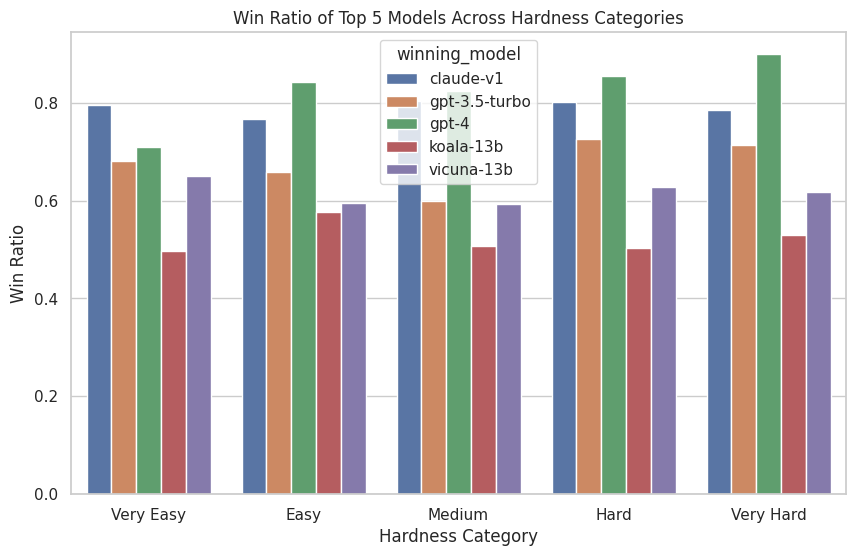

In [97]:
# Plot the results for the top five models
df_cat_top_five = df_win_tot[df_win_tot["winning_model"].isin(top_five)]

# Plot the win ratio for the top five models
plt.figure(figsize=(10, 6))
sns.barplot(data = df_cat_top_five, x='hard_cat', y='win_ratio', hue='winning_model')

# Add labels and title
plt.title('Win Ratio of Top 5 Models Across Hardness Categories')
plt.xlabel('Hardness Category')
plt.ylabel('Win Ratio')
plt.show();

In [98]:
top_five

['gpt-4', 'vicuna-13b', 'gpt-3.5-turbo', 'claude-v1', 'koala-13b']

In [99]:
df_merge["topic_modeling_1"].value_counts().head(10)

topic_modeling_1
Creative Writing                     568
Factual Accuracy                     510
Problem-solving, Creativity          398
Factual Knowledge                    300
Problem Solving                      284
Math Problem                         209
Information Retrieval                188
Problem-solving, Factual accuracy    176
Creativity, Humor                    164
Problem-Solving, Creativity          144
Name: count, dtype: int64

In [100]:
df_merge["topic_modeling_2"].value_counts().head(10)

topic_modeling_2
Creative Writing                     598
Factual Accuracy                     487
Problem-solving, Creativity          407
Factual Knowledge                    314
Problem Solving                      290
Math Problem                         206
Information Retrieval                197
Problem-solving, Factual accuracy    175
Problem-Solving, Creativity          158
Creativity, Humor                    145
Name: count, dtype: int64

In [101]:
df_merge["topic_modeling_3"].value_counts().head(10)

topic_modeling_3
Creative Writing                     598
Factual Accuracy                     487
Problem-solving, Creativity          407
Factual Knowledge                    314
Problem Solving                      290
Math Problem                         206
Information Retrieval                197
Problem-solving, Factual accuracy    175
Problem-Solving, Creativity          158
Creativity, Humor                    145
Name: count, dtype: int64

In [102]:
# Create a datframe grouping topics with their average hardness score
df_topics = df_merge.groupby(["topic_modeling_1"])["avg_score"].mean().reset_index()

# Filter to include the top ten topics.
df_topics[df_topics["topic_modeling_1"].isin(list(df_merge["topic_modeling_1"].value_counts().head(10).index))]

,topic_modeling_1,avg_score
2046,Creative Writing,8.270540
2156,"Creativity, Humor",7.867886
3565,Factual Accuracy,6.976471
3589,Factual Knowledge,6.060000
4952,Information Retrieval,5.666667
5899,Math Problem,6.068581
7742,Problem Solving,7.916667
7765,"Problem-Solving, Creativity",8.046296
7849,"Problem-solving, Creativity",7.909548
7878,"Problem-solving, Factual accuracy",7.498106


### Observations

- How does the hardness score compare with the results from the top five models from the main data set?

The above plot of "Win Ratio of Top 5 Models Across Hardness Categories" shows the correlation between the number of times a model won a competition based on the average hardness score. The hardness categories are bins that represent the average hardness score from the 'topic_and_hardness' dataframe. The bins are structured to contain ranges of values, for example, "Very Easy" is zero to two, "Easy" two to four, and so on. 

From the above plot of we can see that 'gpt-4' outperformed all other models for every category of hardness, except for "Very Easy" questions, where 'claude-v1' was the highest performing model. Interestingly, these results would infer that the order of the top five models would be different than that obtained solely based on win count. The plot shows that 'claude-v1' consistently performed better than 'vicuna-13b' even though 'vicuna-13b' took second in rankings based on win count, and 'claude-v1' was fourth. 

Based on this plot, I would maintain 'gpt-4' as the best performing model, but I would switch the order of 'claude-v1' and 'vicuna-13b' due to the reason discussed above. The rest of the ordering remains the same.

- What are the most common topics?

By taking the value counts of the "topic_modeling" data we can obtain a list of the most common topics in descending order. The top three topics based on this output are: creative writing, factual accuracy, and problem-solving/creativity. Creative writing is the most common with about 600 instances of the topic, which is almost 100 more instances than factual accuracy, and about 200 more instances than problem-solving/creativity. 

- What is the hardness score of the most common topics.

Based on the above dataframe of topics grouped by the mean of the average hardness score, for the top three topics mentioned above the average hardness score is: 8.2, 7.8, and 6.9 respectively.



## Summary and Next Steps

You've now explored various aspects of the dataset, including prompt lengths, response lengths, and embeddings, as well as handling messy data. As you proceed, it's important to remember the key **EDA requirements** for this milestone:

1. **Ranking of the model based on their win rate or ELO ratings**
2. **Distribution of the prompt and response length** 
4. **Hardness score distribution and its correlation with the models** 
5. **Open-ended: Visualize the "variance" in model performance**
6. **Open-ended: Explore the prompt topics in the dataset (topic modeling)**

### What Have You Discovered?

Now that you've completed the initial exploration through this notebook, think about the following:

- **Which insights surprised you?**  
- **What further questions would you ask based on the patterns you've seen?**  
- **Which analyses are still missing or could be extended?**

This notebook provides a foundation for your EDA, but the real insights will come from the questions you ask and the deeper analyses you conduct. Use this notebook as a starting point to explore relationships in the data that will help inform your understanding of chatbot performance. By formulating and answering your questions as a team, you'll gain a richer understanding of the dataset and get ready for the modeling tasks.